### Create dataset for building the model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsbombpy import sb
import utils as utils
import SoccermaticsForPython.FCPython as sfp_fcp
import SoccermaticsForPython as sfp
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### get data - statsbomb API

In [3]:
# check competitions 
competitions = sb.competitions()
competitions.loc[competitions['competition_name'] == 'UEFA Euro']

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
62,55,43,Europe,UEFA Euro,male,False,True,2020,2023-02-24T21:26:47.128979,2023-04-27T22:38:34.970148,2023-04-27T22:38:34.970148,2023-02-24T21:26:47.128979


In [4]:
# select the UEFA euro's from 2020; could be nice to explore what's going on there
matches = sb.matches(competition_id=55, season_id=43)
matches.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3795108,2021-07-02,18:00:00.000,Europe - UEFA Euro,2020,Switzerland,Spain,1,1,available,available,2022-12-01T16:35:19.064845,2023-04-27T21:55:08.695971,5,Quarter-finals,Saint-Petersburg Stadium,Michael Oliver,Vladimir Petković,Luis Enrique Martínez García,1.1.0,2,2
1,3788769,2021-06-21,21:00:00.000,Europe - UEFA Euro,2020,Russia,Denmark,1,4,available,available,2022-12-01T16:23:46.374386,2023-04-27T22:20:21.686564,3,Group Stage,Parken,Clément Turpin,Stanislav Cherchesov,Kasper Hjulmand,1.1.0,2,2
2,3788766,2021-06-20,18:00:00.000,Europe - UEFA Euro,2020,Italy,Wales,1,0,available,available,2022-12-01T16:20:49.842595,2023-04-27T22:22:42.769375,3,Group Stage,Estadio Olímpico,Ovidiu Alin Hațegan,Roberto Mancini,Robert Page,1.1.0,2,2
3,3795220,2021-07-06,21:00:00.000,Europe - UEFA Euro,2020,Italy,Spain,1,1,available,available,2021-08-09T20:41:31.241,2022-08-04T12:00,6,Semi-finals,Wembley Stadium,Felix Brych,Roberto Mancini,Luis Enrique Martínez García,1.1.0,2,2
4,3788761,2021-06-18,15:00:00.000,Europe - UEFA Euro,2020,Sweden,Slovakia,1,0,available,available,2022-12-01T16:17:56.014053,2023-04-27T22:28:52.986485,2,Group Stage,Saint-Petersburg Stadium,Daniel Siebert,Jan Olof Andersson,Štefan Tarkovič,1.1.0,2,2


In [5]:
matches['score'] = matches['home_score'] + matches['away_score']
print('Aantal games:', len(matches['score']),
      'en aantal goals per game', round(np.mean(matches['score']), 2))

Aantal games: 51 en aantal goals per game 2.78


In [6]:
# check what types of matches are found
matches['competition_stage'].value_counts()

Group Stage       36
Round of 16        8
Quarter-finals     4
Semi-finals        2
Final              1
Name: competition_stage, dtype: int64

In [7]:
# select all the events from all the worldcup matches
match_ids = matches['match_id'].unique()
total_events = []

for uniek_id in match_ids:
    events = sb.events(match_id=uniek_id)
    total_events.append(events)

In [8]:
# create one dataframe from all events of the games selected.
events_all_matches = pd.concat(total_events)

#### create identifier

In [9]:
# create a unique identifier of what we want to predict. 
# Scope: In this case we want to predict per match if a goal by the possesion team was made based on previous events by the possession team
events_all_matches['uniekid'] = (events_all_matches['match_id'] * 1000) + events_all_matches['possession_team_id']

In [11]:
events_all_matches.head(1)

,50_50,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,block_save_block,foul_committed_offensive,foul_committed_penalty,foul_won_penalty,goalkeeper_punched_out,injury_stoppage_in_chain,pass_miscommunication,pass_no_touch,pass_straight,dribble_nutmeg,shot_deflected,shot_redirect,bad_behaviour_card,clearance_other,shot_open_goal,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,shot_saved_off_target,shot_saved_to_post,goalkeeper_lost_in_play,goalkeeper_success_in_play,dribble_no_touch,goalkeeper_penalty_saved_to_post,shot_follows_dribble,player_off_permanent,uniekid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2e4b1b7f-e67e-4bef-8cf1-2eab2ab81af2,1,NaN,NaN,3795108,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Switzerland,773,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Switzerland,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3795108773


In [12]:
print('Aantal games die zijn gespeeld: \n', events_all_matches['match_id'].nunique())
print('Aantal uniekids die er zijn (zouden er 2 per wedstrijd moeten zijn):\n', events_all_matches['uniekid'].nunique())
print('gemiddeld aantal schoten per wedstrijd: \n', round(np.mean(events_all_matches.groupby('match_id')['shot_type'].count()),2))

Aantal games die zijn gespeeld: 
 51
Aantal uniekids die er zijn (zouden er 2 per wedstrijd moeten zijn):
 102
gemiddeld aantal schoten per wedstrijd: 
 25.27


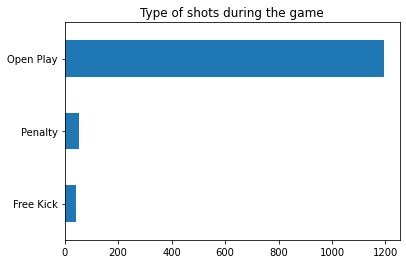

In [13]:
# check a variable, for example: what types of shots do we have?
events_all_matches['shot_type'].value_counts(ascending=True).plot(kind='barh')
plt.title('Type of shots during the game')
plt.show()

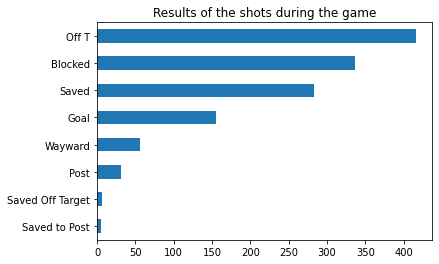

In [14]:
# check another variable, because.. what are the results of all the shots?
events_all_matches['shot_outcome'].value_counts(ascending=True).plot(kind='barh')
plt.title('Results of the shots during the game')
plt.show()

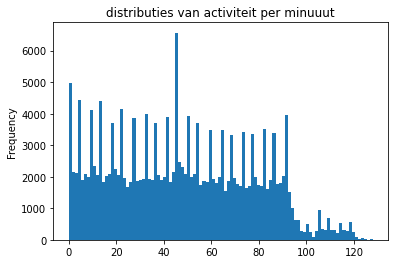

In [15]:
## check events per minute in the game
events_all_matches['minute'].plot(kind='hist', bins=100)
plt.title('distributies van activiteit per minuuut')
plt.show()

In [16]:
events_all_matches.loc[events_all_matches['shot_outcome'] == 'Goal'].head(1)

,50_50,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,block_save_block,foul_committed_offensive,foul_committed_penalty,foul_won_penalty,goalkeeper_punched_out,injury_stoppage_in_chain,pass_miscommunication,pass_no_touch,pass_straight,dribble_nutmeg,shot_deflected,shot_redirect,bad_behaviour_card,clearance_other,shot_open_goal,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,shot_saved_off_target,shot_saved_to_post,goalkeeper_lost_in_play,goalkeeper_success_in_play,dribble_no_touch,goalkeeper_penalty_saved_to_post,shot_follows_dribble,player_off_permanent,uniekid
4683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.070183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8eb56f1e-28e2-4b78-bb25-12bed627d1f4,2722,NaN,"[109.2, 44.9]",3795108,67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Regular Play,Xherdan Shaqiri,3533.0,Center Attacking Midfield,122,Switzerland,773,[428549ad-0b3c-4caf-a0ba-286af8d7bd19],42,NaN,Right Foot,"[120.0, 36.4, 0.1]",True,"[{'location': [95.6, 60.1], 'player': {'id': 5...",144b9dfe-a01b-4df2-8126-e33355335d11,NaN,Goal,0.338265,Normal,Open Play,NaN,NaN,NaN,Switzerland,00:22:42.366,Shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3795108773


In [17]:
# # makes me curious as to how many pk's are scores.. lets see
# events_all_matches.groupby('shot_type')['shot_outcome'].value_counts(normalize=True)  # ok 60% of penalty kicks are scores

In [18]:
# # hoeveel events vinden er voor elk team plaats in een wedstrijd?
# events_per_team = round(np.mean(events_all_matches.groupby('uniekid').size()))
# print('Gem. aantal events per uniekid (per wedstrijd en per team): \n', events_per_team)

In [19]:
# print('max aantal regels per unieke game en team combinatie: ', np.max(events_all_matches.groupby('uniekid').size()))
# print('min aantal regels per unieke game en team combinatie: ', np.min(events_all_matches.groupby('uniekid').size()))

#### data exploration one example

In [20]:
## Let's pick out one game and dive a bit deeper into the dataset
subset_df = events_all_matches.loc[events_all_matches['match_id'] == 3795108]

In [21]:
# check both attacking teams and compare their results
subset_df['team'].value_counts()

Spain          3391
Switzerland    1599
Name: team, dtype: int64

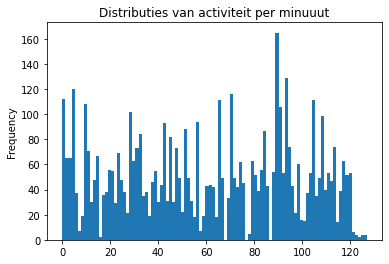

In [22]:
subset_df['minute'].plot(kind='hist', bins=100)
plt.title('Distributies van activiteit per minuuut')
plt.show()

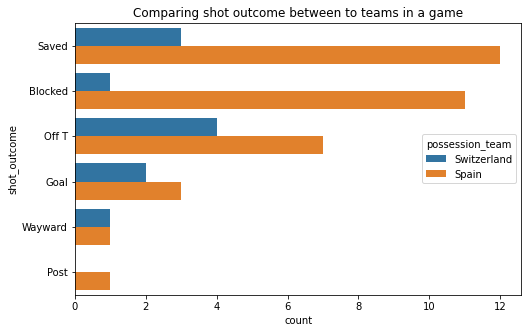

In [23]:
# lets see how both teams act in the game
fix, ax = plt.subplots(figsize=(8,5))
sns.countplot(y='shot_outcome', 
              data = subset_df, 
              hue='possession_team',
              order = subset_df['shot_outcome'].value_counts().index)
plt.title('Comparing shot outcome between to teams in a game')
plt.show()

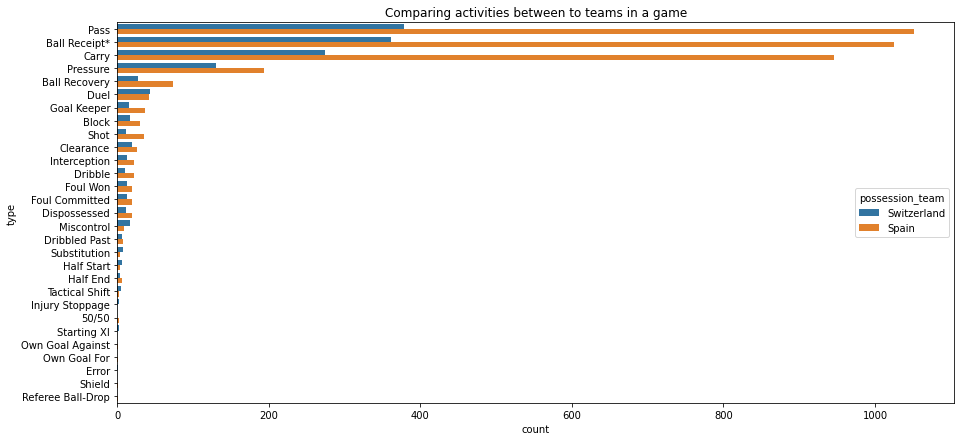

In [24]:
# seems like spain had a lot more going on; lets see what events were occuring
fix, ax = plt.subplots(figsize=(15,7))
sns.countplot(y='type', 
              data = subset_df, 
              hue='possession_team',
              order = subset_df['type'].value_counts().index)
plt.title('Comparing activities between to teams in a game')
plt.show()

#### create y-variable for the model

In [25]:
# little reminder of what the dataset looks like
events_all_matches.head(1)   # got quite some descriptive columns to figure out later..

,50_50,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,block_save_block,foul_committed_offensive,foul_committed_penalty,foul_won_penalty,goalkeeper_punched_out,injury_stoppage_in_chain,pass_miscommunication,pass_no_touch,pass_straight,dribble_nutmeg,shot_deflected,shot_redirect,bad_behaviour_card,clearance_other,shot_open_goal,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,shot_saved_off_target,shot_saved_to_post,goalkeeper_lost_in_play,goalkeeper_success_in_play,dribble_no_touch,goalkeeper_penalty_saved_to_post,shot_follows_dribble,player_off_permanent,uniekid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2e4b1b7f-e67e-4bef-8cf1-2eab2ab81af2,1,NaN,NaN,3795108,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Switzerland,773,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Switzerland,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3795108773


In [26]:
# select the columns that are relevant for the predicting variable
column_selection = ['uniekid', 'match_id', 'peil_minute', 'y_minute', 'goal']

# function that creates dataframe with the prediction of a goal
# we want to predict one minute ahead so our peil moment is one minute prior to the goal
df_goals = utils.create_goal_df(events_all_matches, 'Goal', column_selection)
df_goals.head()

,uniekid,match_id,peil_minute,y_minute,goal
0,3795108773,3795108,66,67,1
1,3795108773,3795108,120,121,1
2,3795108772,3795108,120,121,1
3,3795108772,3795108,124,125,1
4,3795108772,3795108,126,127,1


In [27]:
# function that creates dataframe with the prediction of NO goal
# all the minutes in which no goal was scores are selected as no goal minutes and all these events are then selected
uniek_id_list = events_all_matches['uniekid'].unique()
column_selection = ['uniekid', 'match_id', 'peil_minute', 'y_minute', 'goal']
df_no_goals = utils.create_no_goals_df(events_all_matches, df_goals, uniek_id_list, column_selection)
df_no_goals.head()

,uniekid,match_id,peil_minute,y_minute,goal
0,3795108773,3795108,0,1,0
1,3795108773,3795108,1,2,0
2,3795108773,3795108,2,3,0
3,3795108773,3795108,3,4,0
4,3795108773,3795108,4,5,0


In [28]:
# create dataframe with all goal/no goal predictors for each minute in the game
yvar = pd.concat([df_goals,df_no_goals])
yvar['match_id'] = yvar['match_id'].astype(str)

In [29]:
yvar.head()

,uniekid,match_id,peil_minute,y_minute,goal
0,3795108773,3795108,66,67,1
1,3795108773,3795108,120,121,1
2,3795108772,3795108,120,121,1
3,3795108772,3795108,124,125,1
4,3795108772,3795108,126,127,1


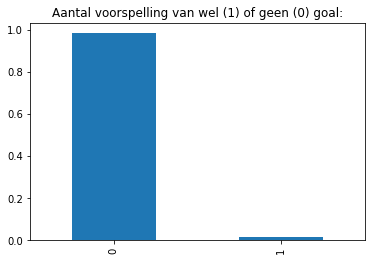

In [30]:
# lets see the distribution of our prediction variable (as was expected it is a highley imbalanced dataset)
yvar['goal'].value_counts(normalize=True).plot(kind='bar')
plt.title('Aantal voorspelling van wel (1) of geen (0) goal:')
plt.show()

#### select static x-variables from each game

In [31]:
static_data_matches = matches[['match_id', 'competition_stage']]
static_data_matches.head()

,match_id,competition_stage
0,3795108,Quarter-finals
1,3788769,Group Stage
2,3788766,Group Stage
3,3795220,Semi-finals
4,3788761,Group Stage


In [32]:
# create dummy-variables for the type of game that we have
dummie_categories = ['competition_stage']
df_dummies = pd.get_dummies(static_data_matches[dummie_categories])

# add dummy columns to dataset and drop old columns
static_data_matches_dummies = pd.concat([static_data_matches, df_dummies], axis=1)
static_data_matches_dummies = static_data_matches_dummies.drop(dummie_categories,axis = 1)
static_data_matches_dummies['match_id'] = static_data_matches_dummies['match_id'].astype(str)
static_data_matches_dummies.head(1)

,match_id,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals
0,3795108,0,0,1,0,0


In [33]:
# add this variable to the y-variable dataframe based on game-id
left_keys = ['match_id']
right_keys = ['match_id']
yvar_static_data = pd.merge(yvar, static_data_matches_dummies, left_on=left_keys, right_on=right_keys, how='left')

In [34]:
yvar_static_data.head(1)

,uniekid,match_id,peil_minute,y_minute,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals
0,3795108773,3795108,66,67,1,0,0,1,0,0


In [35]:
# yvar_static_data.loc[yvar_static_data['uniekid'] == 3788753796]

#### select dynamic x-variables from each uniekid (team per game)

In [36]:
events_all_matches.head(1)

,50_50,ball_receipt_outcome,ball_recovery_offensive,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_type,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,interception_outcome,location,match_id,minute,miscontrol_aerial_won,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_outcome,pass_outswinging,pass_recipient,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_replacement,tactics,team,timestamp,type,under_pressure,block_save_block,foul_committed_offensive,foul_committed_penalty,foul_won_penalty,goalkeeper_punched_out,injury_stoppage_in_chain,pass_miscommunication,pass_no_touch,pass_straight,dribble_nutmeg,shot_deflected,shot_redirect,bad_behaviour_card,clearance_other,shot_open_goal,goalkeeper_shot_saved_off_target,goalkeeper_shot_saved_to_post,shot_saved_off_target,shot_saved_to_post,goalkeeper_lost_in_play,goalkeeper_success_in_play,dribble_no_touch,goalkeeper_penalty_saved_to_post,shot_follows_dribble,player_off_permanent,uniekid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2e4b1b7f-e67e-4bef-8cf1-2eab2ab81af2,1,NaN,NaN,3795108,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Switzerland,773,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Switzerland,00:00:00.000,Starting XI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3795108773


In [37]:
## Check the following dynamic variables that seem relevant (based on knowledge from a soccer expert (a.k.a. myself ;-))
# dynamic variables are variables that variate within the game for each prediction event

# position = name of the position the play was in in the moment of the play
# location = on the field: higher is attack, lower is more in defensive mode (always left to right)
# under_pressure = action was done under pressure
# player = player that does the event
# possession_team = team that has the possession

In [38]:
column_selection_events = ['uniekid', 'possession_team','player', 'minute','second', 'location', 'position', 'play_pattern', 'type','under_pressure']
events_for_all_matches = utils.get_events_per_id(events_all_matches,column_selection_events, uniek_id_list)

In [39]:
events_for_all_matches.head(1)

,uniekid,possession_team,player,minute,second,location,position,play_pattern,type,under_pressure
93,3795108773,Switzerland,Manuel Obafemi Akanji,4,26,"[8.2, 5.0]",Left Center Back,Regular Play,Pass,NaN


In [40]:
# We do some extra engeneering on these variables to create relevant features
# under_pressure is turned into a dummy (i.e. 1 or 0)
# location is used to determine attacking or not (i.e. aanvallende_helft, aanvallende_kwart, in_de_16)

# run function
events_all_matches_clean = utils.events_feature_engineering(events_for_all_matches)
events_all_matches_clean = events_all_matches_clean.set_index(['uniekid', 'minute', 'second'])

In [41]:
events_all_matches_clean.head(1)

,,,possession_team,player,position,play_pattern,type,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16
uniekid,minute,second,,,,,,,,,
3795108773,4,26,Switzerland,Manuel Obafemi Akanji,Left Center Back,Regular Play,Pass,0,0.0,0.0,0


In [42]:
# Next we turn the other variables into dummy variables that can be used for a model

# create dummy-variables
dummie_categories = ['possession_team', 'player','position', 'play_pattern', 'type']
df_dummies = pd.get_dummies(events_all_matches_clean[dummie_categories])

#add dummy columns to dataset and drop old columns
events_all_matches_clean_dummies = pd.concat([events_all_matches_clean, df_dummies], axis=1)
events_all_matches_clean_dummies = events_all_matches_clean_dummies.drop(dummie_categories,axis = 1).reset_index()
events_all_matches_clean_dummies.drop('second', axis=1,inplace=True)
events_all_matches_clean_dummies.head(1)

,uniekid,minute,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Chris Mepham,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,player_Daniel O''Shaughnessy,player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian Grillitsch,player_Francesco Acerbi,player_Fredrik Jensen,player_Frenkie de Jong,player_Gaetano Castrovilli,player_Gareth Frank Bale,player_Georginio Wijnaldum,player_G

In [44]:
# quick check if we didn't do anything wrong while create the dummies

events_all_matches_clean = events_all_matches_clean.reset_index()
print('Check of aantal rijen in de dummy-set gelijk is aan volgende df: ',
len(events_all_matches_clean.loc[
    (events_all_matches_clean['uniekid'] == 3788741909) &
    (events_all_matches_clean['minute'] == 1) ]))

print('Check of aantal rijen in de dummy-set gelijk is aan vorige df: ',
len(events_all_matches_clean_dummies.loc[
    (events_all_matches_clean_dummies['uniekid'] == 3788741909) &
    (events_all_matches_clean_dummies['minute'] == 1) ]))

Check of aantal rijen in de dummy-set gelijk is aan volgende df:  24
Check of aantal rijen in de dummy-set gelijk is aan vorige df:  24


In [87]:
# events_all_matches_clean_dummies.groupby(['uniekid','minute'])['under_pressure'].sum()

In [45]:
# we have multiple events per minute; so now we create one row; which aggregates all events per minute for each unique id
aggregated_per_minute = utils.aggregate_events_per_minute(events_all_matches_clean_dummies, ['uniekid','minute'], agg_type_max=True) # define max for not aggergated. Can be changed to sum

In [89]:
aggregated_per_minute.head(5)

,uniekid,minute,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Chris Mepham,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,player_Daniel O''Shaughnessy,player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian Grillitsch,player_Francesco Acerbi,player_Fredrik Jensen,player_Frenkie de Jong,player_Gaetano Castrovilli,player_Gareth Frank Bale,player_Georginio Wijnaldum,player_G

#### first use past minute to predict future minute

In [52]:
# # samenvoegen van y en x variabelen based on the activities prior to the current minute
# left_keys = ['uniekid', 'peil_minute']
# right_keys = ['uniekid','minute']
# total_df = pd.merge(yvar_static_data, aggregated_per_minute, left_on=left_keys, right_on=right_keys, how='outer').sort_values(by='minute')
# clean_total_df = total_df.drop(['match_id', 'peil_minute', 'y_minute', 'minute'], axis=1).sort_values(by='uniekid')
# clean_total_df = clean_total_df.fillna(0)
# clean_total_df.to_csv('../data/1min_train_dataset.csv')

#### create one dataframe where we aggregate all the events prior to peil-datum

In [53]:
yvar_static_data.head()

,uniekid,match_id,peil_minute,y_minute,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals
0,3795108773,3795108,66,67,1,0,0,1,0,0
1,3795108773,3795108,120,121,1,0,0,1,0,0
2,3795108772,3795108,120,121,1,0,0,1,0,0
3,3795108772,3795108,124,125,1,0,0,1,0,0
4,3795108772,3795108,126,127,1,0,0,1,0,0


In [60]:
%%time
# take 5 or 10 minutes prior to the peil-datum!
# pay attention, this takes about 30 minutes, needs to be optimalized in production. But does the job for now..
# this script aggregates all features from the events within N minutes prior to the prediction (peil_datum)

total_df_aggregated_per_event = []

for key, value in yvar_static_data.iterrows():  
    uniek_id = value['uniekid']
    peil_minute = value['peil_minute']
    begin_minute = peil_minute - 10      # 5, 10 is nr of minutes to check back from peil_datum
    range_of_minutes = list(range(begin_minute, peil_minute))

    # dataframe per peil_datum to analyze
    df_to_aggregate_per_event = aggregated_per_minute.loc[(aggregated_per_minute['uniekid'] == uniek_id) & aggregated_per_minute['minute'].isin(range_of_minutes)]
    x_vars = df_to_aggregate_per_event.columns[~df_to_aggregate_per_event.columns.isin(['uniekid', 'minute'])]

    # aggregate the events per peil_datum
    total_sum = []
    for col in x_vars:
        col_sum = df_to_aggregate_per_event.groupby(['uniekid'])[col].sum()
        total_sum.append(col_sum)

    df_aggregated_per_event = pd.concat(total_sum, axis=1)
    df_aggregated_per_event['minute'] = peil_minute
    total_df_aggregated_per_event.append(df_aggregated_per_event)
    
## final dataframe
final_agg_df = pd.concat(total_df_aggregated_per_event, axis=0)
final_agg_df.head()

KeyboardInterrupt: 

In [55]:
# now we need to append it to this dataframe
yvar_static_data.head()

,uniekid,match_id,peil_minute,y_minute,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals
0,3795108773,3795108,66,67,1,0,0,1,0,0
1,3795108773,3795108,120,121,1,0,0,1,0,0
2,3795108772,3795108,120,121,1,0,0,1,0,0
3,3795108772,3795108,124,125,1,0,0,1,0,0
4,3795108772,3795108,126,127,1,0,0,1,0,0


In [56]:
len(final_agg_df)

9697

In [57]:
len(yvar_static_data)

9936

In [58]:
# samenvoegen van y en x variabelen 
left_keys = ['uniekid', 'peil_minute']
right_keys = ['uniekid','minute']
total_df = pd.merge(yvar_static_data, final_agg_df, left_on=left_keys, right_on=right_keys, how='outer').sort_values(by='minute')

In [59]:
total_df.to_csv('../data/10min_train_dataset.csv')

In [61]:
total_df = pd.read_csv('../data/10min_train_dataset.csv', index_col=0)

In [62]:
total_df.head()

,uniekid,match_id,peil_minute,y_minute,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Chris Mepham,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,player_Daniel O''Shaughnessy,player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_

In [63]:
# drop irrelevant columns for the model analysis
clean_total_df = total_df.drop(['match_id', 'peil_minute', 'y_minute', 'minute'], axis=1).sort_values(by='uniekid')

In [64]:
clean_total_df = clean_total_df.fillna(0)

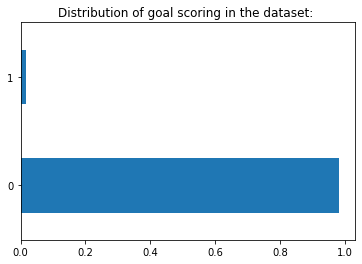

In [65]:
clean_total_df['goal'].value_counts(normalize=True).plot(kind='barh')
plt.title('Distribution of goal scoring in the dataset: ')
plt.show()

#### test some quick hypothesis per variable

In [66]:
clean_total_df.head()

,uniekid,goal,competition_stage_Final,competition_stage_Group Stage,competition_stage_Quarter-finals,competition_stage_Round of 16,competition_stage_Semi-finals,under_pressure,aanvallende_helft,aanvallend_kwart,in_de_16,possession_team_Austria,possession_team_Belgium,possession_team_Croatia,possession_team_Czech Republic,possession_team_Denmark,possession_team_England,possession_team_Finland,possession_team_France,possession_team_Germany,possession_team_Hungary,possession_team_Italy,possession_team_Netherlands,possession_team_North Macedonia,possession_team_Poland,possession_team_Portugal,possession_team_Russia,possession_team_Scotland,possession_team_Slovakia,possession_team_Spain,possession_team_Sweden,possession_team_Switzerland,possession_team_Turkey,possession_team_Ukraine,possession_team_Wales,player_Aaron Ramsey,player_Adam Hložek,player_Adama Traoré Diarra,player_Admir Mehmedi,player_Adrien Rabiot,player_Albin Ekdal,player_Aleksandar Dragović,player_Aleksandar Trajkovski,player_Aleksandr Golovin,player_Aleksandr Sobolev,player_Aleksey Miranchuk,player_Alessandro Bastoni,player_Alessandro Florenzi,player_Alessandro Schöpf,player_Alex Král,player_Alexander Isak,player_Andrea Belotti,player_Andreas Christensen,player_Andreas Evald Cornelius,player_Andreas Skov Olsen,player_Andreas Ulmer,player_Andrej Kramarić,player_Andrew Robertson,player_Andrey Semenov,player_Andriy Yarmolenko,player_András Schäfer,player_André Miguel Valente Silva,player_Anga Dedryck Boyata,player_Ante Budimir,player_Ante Rebić,player_Antoine Griezmann,player_Anton Shunin,player_Antonio Rüdiger,player_Antonín Barák,player_Arijan Ademi,player_Artem Besedin,player_Artem Dovbyk,player_Artem Dzyuba,player_Attila Fiola,player_Attila Szalai,player_Axel Witsel,player_Aymeric Laporte,player_Bartosz Bereszyński,player_Ben Davies,player_Benjamin Pavard,player_Bernardo Mota Veiga de Carvalho e Silva,player_Billy Gilmour,player_Boban Nikolov,player_Borna Barišić,player_Breel-Donald Embolo,player_Bruno Miguel Borges Fernandes,player_Bruno Petković,player_Bryan Cristante,player_Bukayo Saka,player_Burak Yılmaz,player_Caglar Söyüncü,player_Callum McGregor,player_Cengiz Umut Meraş,player_Cengiz Ünder,player_Che Adams,player_Chris Gunter,player_Chris Mepham,player_Christian Benteke Liolo,player_Christian Dannemann Eriksen,player_Christian Fassnacht,player_Christian Nørgaard,player_Christoph Baumgartner,player_Christopher Trimmel,player_Ciro Immobile,player_Clément Lenglet,player_Cody Mathès Gakpo,player_Connor Roberts,player_Corentin Tolisso,player_Cristiano Ronaldo dos Santos Aveiro,player_César Azpilicueta Tanco,player_Daler Kuzyaev,player_Daley Blind,player_Daniel Avramovski,player_Daniel Bachmann,player_Daniel James,player_Daniel O''Shaughnessy,player_Daniel Olmo Carvajal,player_Daniel Wass,player_Danilo Luís Hélio Pereira,player_Danny Ward,player_Darko Churlinov,player_Darko Velkovski,player_David Brooks,player_David Marshall,player_David Olatukunbo Alaba,player_David Siger,player_Declan Rice,player_Dejan Kulusevski,player_Dejan Lovren,player_Denis Cheryshev,player_Denis Lemi Zakaria Lako Lado,player_Dennis Praet,player_Denzel Dumfries,player_Diogo José Teixeira da Silva,player_Djibril Sow,player_Dmitriy Barinov,player_Domagoj Vida,player_Domenico Berardi,player_Dominic Calvert-Lewin,player_Dominik Livaković,player_Donyell Malen,player_Dorukhan Toköz,player_Dries Mertens,player_Duje Ćaleta-Car,player_Dylan Levitt,player_Dávid Hancko,player_Eden Hazard,player_Eduard Sobol,player_Egzon Bejtulai,player_Eljif Elmas,player_Emerson Palmieri dos Santos,player_Emil Krafth,player_Emil Peter Forsberg,player_Emre Can,player_Endre Botka,player_Enis Bardhi,player_Eric García Martret,player_Ethan Ampadu,player_Evgeny Makarenko,player_Ezgjan Alioski,player_Fabian Lukas Schär,player_Fabián Ruiz Peña,player_Federico Bernardeschi,player_Federico Chiesa,player_Fedor Kudryashov,player_Ferhan Hasani,player_Ferrán Torres García,player_Filip Helander,player_Florian Grillitsch,player_Fran

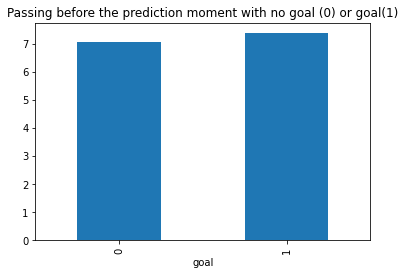

In [67]:
## more in aanvallend_kwart bij goals
clean_total_df.groupby('goal')['type_Pass'].mean().plot(kind='bar')
plt.title('Passing before the prediction moment with no goal (0) or goal(1)')
plt.show()

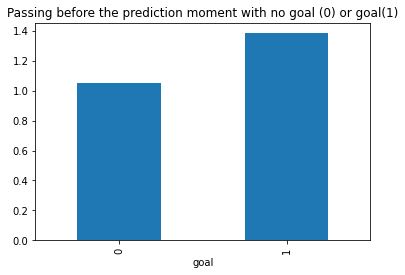

In [68]:
## more in aanvallend_kwart bij goals
clean_total_df.groupby('goal')['type_Shot'].mean().plot(kind='bar')
plt.title('Passing before the prediction moment with no goal (0) or goal(1)')
plt.show()

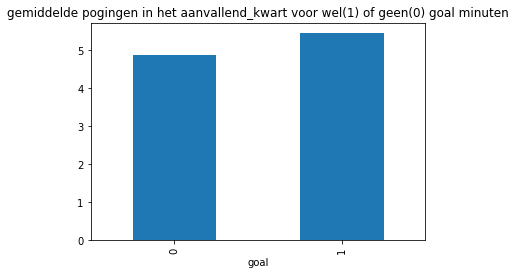

In [69]:
## more in aanvallend_kwart bij goals
clean_total_df.groupby('goal')['aanvallend_kwart'].mean().plot(kind='bar')
plt.title('gemiddelde pogingen in het aanvallend_kwart voor wel(1) of geen(0) goal minuten')
plt.show()

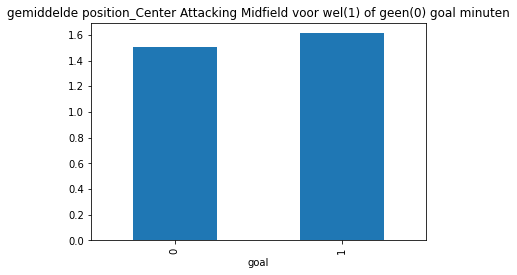

In [70]:
## more aanvallende positie bij goals?
clean_total_df.groupby('goal')['position_Center Attacking Midfield'].mean().plot(kind='bar')
plt.title('gemiddelde position_Center Attacking Midfield voor wel(1) of geen(0) goal minuten')
plt.show()